In [73]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torch.nn.functional as F

from torch.cuda.amp import GradScaler, autocast
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 

from sklearn.preprocessing import MinMaxScaler, PowerTransformer
from scipy import stats
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.set_float32_matmul_precision('high')

import torch._dynamo
torch._dynamo.config.verbose = True
torch._dynamo.config.suppress_errors = True

In [77]:
input_file = r'D:\School\ADMU\4Y\SEM 1\MATH 199.11\Daily Data\LUZ\LUZ_Daily.csv'
data = pd.read_csv(input_file)

data = data[['GWAP', 'FLOW_LUZ','RESERVE_GWAP_Fr'	,'RESERVE_GWAP_Ru'	,'RESERVE_GWAP_Rd'	,'RESERVE_GWAP_Dr',	'Hourly Demand']]  # Select the relevant time series column
data = data.fillna(0)


data['GWAP'],_ = stats.boxcox(data['GWAP'] + 1)  # Box-Cox transformation

pt = PowerTransformer(method='yeo-johnson')
data[['RESERVE_GWAP_Fr', 'RESERVE_GWAP_Ru', 'RESERVE_GWAP_Rd', 'RESERVE_GWAP_Dr']] = pt.fit_transform(data[['RESERVE_GWAP_Fr', 'RESERVE_GWAP_Ru', 'RESERVE_GWAP_Rd', 'RESERVE_GWAP_Dr']])
# Use all columns as features (X)
scaler = MinMaxScaler(feature_range=(0, 1))
data[['GWAP', 'FLOW_LUZ', 'RESERVE_GWAP_Fr', 'RESERVE_GWAP_Ru', 'RESERVE_GWAP_Rd', 'RESERVE_GWAP_Dr', 'Hourly Demand']] = scaler.fit_transform(data[['GWAP', 'FLOW_LUZ', 'RESERVE_GWAP_Fr', 'RESERVE_GWAP_Ru', 'RESERVE_GWAP_Rd', 'RESERVE_GWAP_Dr', 'Hourly Demand']])
X = data.values

# Use 'GWAP' column as the target (y)
y = data['GWAP'].values.reshape(-1, 1)

NaN values in data after Min-Max scaling:
GWAP               0
FLOW_LUZ           0
RESERVE_GWAP_Fr    0
RESERVE_GWAP_Ru    0
RESERVE_GWAP_Rd    0
RESERVE_GWAP_Dr    0
Hourly Demand      0
dtype: int64


In [78]:
class TimeSeriesDataset(Dataset):
    
    def __init__(self, X, y, seq_len):
        self.X = torch.tensor(X).float()
        self.y = torch.tensor(y).float()
        self.seq_len = seq_len
    
    def __len__(self):
        return len(self.X) - self.seq_len + 1
        
    def __getitem__(self, idx):
        return (self.X[idx:idx+self.seq_len], self.y[idx+self.seq_len-1])

In [79]:
train_size = int(0.7 * len(X))  # 70% for training
val_size = int(0.20 * len(X))   # 15% for validation
test_size = len(X) - train_size - val_size  # Remaining 15% for testing

train_data = X[:train_size]
train_labels = y[:train_size]

val_data = X[train_size:train_size + val_size]
val_labels = y[train_size:train_size + val_size]

test_data = X[train_size + val_size:]
test_labels = y[train_size + val_size:]
seq_len=7
batch_size=64

train_dataset = TimeSeriesDataset(train_data, train_labels, seq_len)
train_dataloader = DataLoader(train_dataset, batch_size, shuffle=False)

val_dataset = TimeSeriesDataset(val_data, val_labels, seq_len)    
val_dataloader = DataLoader(val_dataset, batch_size, shuffle=False) 

test_dataset = TimeSeriesDataset(test_data, test_labels, seq_len)
test_dataloader = DataLoader(test_dataset, batch_size, shuffle=False)


In [80]:
print(len(train_dataset), len(val_dataset), len(test_dataset))

504 140 68


In [39]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # LSTM layer
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        # Fully connected layer
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):

    
        # Forward propagate LSTM
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])  # Take the output from the last time step
        return out

In [81]:
class LSTMCustomCell(nn.Module):
    def __init__(self, input_size, hidden_size, activation_fn):
        super(LSTMCustomCell, self).__init__()
        self.hidden_size = hidden_size
        self.activation_fn = activation_fn
        
        # Combine all gate matrices into one large matrix for efficiency
        self.W_ih = nn.Linear(input_size, 4 * hidden_size, bias=False)
        self.W_hh = nn.Linear(hidden_size, 4 * hidden_size, bias=False)
        self.bias = nn.Parameter(torch.zeros(4 * hidden_size))
        
    def forward(self, x, hidden):
        h, c = hidden
        
        # Optimized matrix multiplication and bias addition
        gates = self.W_ih(x) + self.W_hh(h) + self.bias
        
        # Split into 4 gate vectors
        i_gate, f_gate, o_gate, g_gate = torch.chunk(gates, 4, dim=1)
        
        # Sigmoid activations for gates
        i_gate = torch.sigmoid(i_gate)
        f_gate = torch.sigmoid(f_gate)
        o_gate = torch.sigmoid(o_gate)
        
        # Apply the custom activation function for the cell gate
        g_gate = self.activation_fn(g_gate)
        
        # Compute the new cell state
        c_next = f_gate * c + i_gate * g_gate
        
        # Compute the new hidden state using the custom activation function
        h_next = o_gate * self.activation_fn(c_next)
        
        return h_next, c_next

In [82]:
class LSTMCustom(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=1, activation_fn=torch.tanh, batch_first=False):
        super(LSTMCustom, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.activation_fn = activation_fn
        self.batch_first = batch_first
        
        # Create a list of LSTM cells
        self.cells = nn.ModuleList([LSTMCustomCell(input_size if i == 0 else hidden_size, hidden_size, activation_fn) for i in range(num_layers)])
        
    def forward(self, x, hidden=None):
        # Determine the correct input shape
        if self.batch_first:
            batch_size, seq_len, _ = x.size()
            x = x.transpose(0, 1)  # Convert to (seq_len, batch_size, input_size) for processing
        else:
            seq_len, batch_size, _ = x.size()
        
        if hidden is None:
            # Initialize hidden and cell states with zeros
            h = [torch.zeros(batch_size, self.hidden_size, device=x.device) for _ in range(self.num_layers)]
            c = [torch.zeros(batch_size, self.hidden_size, device=x.device) for _ in range(self.num_layers)]
        else:
            h, c = hidden
        
        outputs = []
        
        # Iterate over each time step
        for t in range(seq_len):
            x_t = x[t, :, :]  # Input at time step t
            for i, cell in enumerate(self.cells):
                h[i], c[i] = cell(x_t, (h[i], c[i]))
                x_t = h[i]  # Pass hidden state to the next layer
            outputs.append(h[-1].unsqueeze(0))  # Collect output from the last layer
        
        # Stack the outputs across time steps
        outputs = torch.cat(outputs, dim=0)
        
        # Convert output back to (batch_size, seq_len, hidden_size) if batch_first is True
        if self.batch_first:
            outputs = outputs.transpose(0, 1)
        
        # Return outputs and the last hidden and cell states
        return outputs, (torch.stack(h), torch.stack(c))



In [90]:
# Define model parameters
input_size = train_data.shape[1]  # Number of features
hidden_size = 128
output_size = train_labels.shape[1]  # Number of output features
num_layers = 2
#model = LSTMModel(input_size, hidden_size,output_size, num_layers).to(device)

activation_fn = torch.relu
model = LSTMCustom(input_size, hidden_size, num_layers, activation_fn, batch_first=True).to(device)

# Add a fully connected layer for the output (since we removed it from the LSTM itself)
fc = nn.Linear(hidden_size, output_size).to(device)

# Define loss function and optimizer
criterion = nn.MSELoss()  # Use MSE loss for regression tasks
optimizer = optim.AdamW(list(model.parameters()) + list(fc.parameters()), lr=1e-4, weight_decay=1e-5)


In [84]:
#model = torch.compile(model)

In [91]:
scaler = torch.amp.GradScaler()

def train(model, fc, train_dataloader, device, optimizer, criterion):
    model.train()
    total_loss = 0.0  # Initialize total loss to 0

    
    for i, (inputs, target) in enumerate(train_dataloader):
        
        inputs, target = inputs.to(device), target.to(device)
        
        optimizer.zero_grad()
        
        # Forward pass
        outputs, _ = model(inputs)  # Unpack the output tuple
        
        
        
        # Apply the fully connected layer to each time step's output
        outputs = outputs[:, -1, :]
        
        predictions = fc(outputs).to(device)
    
        
    
        loss = criterion(predictions, target)
         
        
        # Backward pass
        loss.backward()
        optimizer.step()

        # Accumulate the loss
        total_loss += loss.item() * inputs.size(0)

    # Return the average loss over all batches
    return total_loss / len(train_dataloader.dataset)
        
       

In [92]:
@torch.no_grad()
def evaluate(model,fc, dataloader, device, criterion):
    model.eval()
    total_loss = 0.0  # Initialize total loss


    for i, (inputs, target) in enumerate(dataloader):  # Use `test_dataloader`
        inputs, target = inputs.to(device), target.to(device)

        # Forward pass
        outputs, _ = model(inputs)
        outputs = outputs[:, -1, :]
        
        predictions = fc(outputs).to(device)
    
        
    
        loss = criterion(predictions, target)

        # Accumulate the loss
        total_loss += loss.item() * inputs.size(0)

    # Return the average loss over all batches
    
    return total_loss/len(dataloader.dataset)


In [96]:
train_losses = []
val_losses = []
test_losses = []
def run(model, train_dataloader, val_dataloader, test_dataloader, device, epoch,optimizer):
    
    
    for epoch in range(epoch):
        
        train_loss = train(model,fc, train_dataloader, device, optimizer, criterion)
        train_losses.append(train_loss)
        val_loss=evaluate(model,fc,val_dataloader,device,criterion)
        val_losses.append(val_loss)
        test_loss = evaluate(model, fc,test_dataloader, device,criterion)
        test_losses.append(test_loss)
        print(f"Epoch {epoch+1}, Training Loss: {train_loss}, Val Loss: {val_loss}, Test Loss: {test_loss}")
        if (epoch + 1) == 100 or (epoch + 1) % 20 == 0:
            print(f'Epoch {epoch+1:04d} | loss: {train_loss:.4f} '
                f'test_loss: {test_loss:.4f} ')
    
        if train_loss < 1e-3 and test_loss < 1e-3:
            break

In [97]:
epoch=100
run(model, train_dataloader,val_dataloader, test_dataloader, device, epoch,optimizer)

Epoch 1, Training Loss: 0.0006451181991631905, Val Loss: 0.002298843501401799, Test Loss: 0.005367172758697587
Epoch 2, Training Loss: 0.0006902552577519109, Val Loss: 0.0010271337482013873, Test Loss: 0.0036108620355234425
Epoch 3, Training Loss: 0.0008211300102254701, Val Loss: 0.0007477090627487216, Test Loss: 0.0020714757830479786
Epoch 4, Training Loss: 0.000614527908582536, Val Loss: 0.000801480539874839, Test Loss: 0.00173837981214199
Epoch 5, Training Loss: 0.0005017023488310062, Val Loss: 0.0010450587973796896, Test Loss: 0.002376327380154501
Epoch 6, Training Loss: 0.0006659543141722679, Val Loss: 0.0019485321195263949, Test Loss: 0.003922198132118758
Epoch 7, Training Loss: 0.000638955168329948, Val Loss: 0.002329877617635897, Test Loss: 0.005106961477876586
Epoch 8, Training Loss: 0.0005736639589211712, Val Loss: 0.001212960431751396, Test Loss: 0.00395216779125964
Epoch 9, Training Loss: 0.0007811563906245052, Val Loss: 0.0006931273948534259, Test Loss: 0.00223020295722081

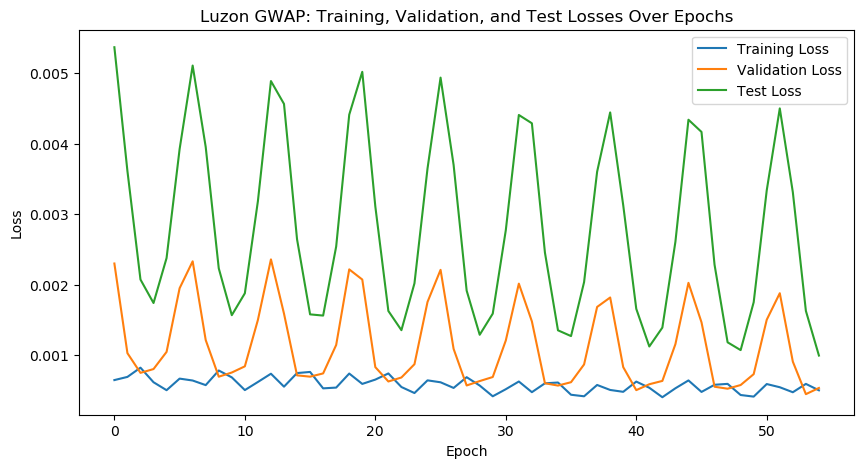

In [101]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Luzon GWAP: Training, Validation, and Test Losses Over Epochs')
plt.savefig('losses.png')
plt.show()
